In [42]:
%%time

import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

from sklearn.neighbors import KDTree

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score
from core.cluster_validation import get_linkage_matrix

# try hdbscan extraction
from fast_hdbscan.boruvka import parallel_boruvka
from fast_hdbscan.cluster_trees import (
    cluster_tree_from_condensed_tree,
    condense_tree,
    extract_eom_clusters,
    extract_leaves,
    get_cluster_label_vector,
    mst_to_linkage_tree,
)
from fast_hdbscan.numba_kdtree import kdtree_to_numba
from sklearn.neighbors import KDTree

CPU times: user 21 μs, sys: 4 μs, total: 25 μs
Wall time: 26 μs


In [43]:
def preprocess_clustering_data(X_train):
    X_train = X_train[X_train.index >= 0]


    to_drop = [
     'stcSAl',
     'ltkOri',
     'stbOri',
     'stcOri',
     'stbCeA',
    
    # #not in barcelona
     # 'ltcBuA', 
    #  'midRea',
    #  'midAre',
    #  'likWBB'

    #  'sdbPer', 
    #  'sdbCoA',
    #  'ssbCCM',
    #  'ltbIBD',
    #  'sdcLAL',
    #  'sdcAre',
    #  'sscERI',
    #  'mtcWNe',
    #  'mdcAre',
    #  'ltcWRB',
    #  'sicCAR',
    # "mtdDeg",


 #        'sdbPer',
 # 'sdbCoA',
 # 'ssbCCo',
 # 'ssbCor',
 # 'ssbERI',
 # 'ssbElo',
 # 'ltcBuA',
 # 'sdcAre',
 # 'stcSAl',


        # 'sdbCoA', 'ssbERI', 'mtdDeg', 'sscERI'
        
    ]
    
    all_drop = []
    for c in to_drop:
        all_drop += X_train.columns[X_train.columns.str.contains(c)].tolist()

    X_train = X_train.drop(all_drop, axis=1)
    
    vals = StandardScaler().fit_transform(X_train)
    X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)
    
    vals = np.nan_to_num(X_train)
    X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)
    
    stats = X_train.describe()
    X_train = X_train.drop(stats.columns[stats.loc['std'] == 0], axis=1)

    return X_train

def get_tree(training_data, clustering_graph, linkage, metric):

    clusterer = AgglomerativeClustering(linkage=linkage,
                                        connectivity = clustering_graph,
                                        metric=metric,
                                        compute_full_tree=True,
                                        compute_distances=True)
    model = clusterer.fit(training_data)
    linkage_matrix = get_linkage_matrix(model)
    return linkage_matrix

def get_clusters(linkage_matrix, min_cluster_size, eom_clusters=True):

    condensed_tree = condense_tree(linkage_matrix, 
                               min_cluster_size=min_cluster_size)
    cluster_tree = cluster_tree_from_condensed_tree(condensed_tree)

    if eom_clusters:
        selected_clusters = extract_eom_clusters(
            condensed_tree, cluster_tree, allow_single_cluster=False
        )
    else:
        selected_clusters = extract_leaves(
                condensed_tree, allow_single_cluster=False
            )
    return get_cluster_label_vector(condensed_tree, selected_clusters, 0)

In [44]:
def post_process_clusters(component_buildings_data, component_graph, component_clusters):


    component_clusters = component_clusters.copy()

    ## if all the poitns are noise try leaf clustering
    if (component_clusters == -1).all():
       component_clusters = get_clusters(ward_tree, min_cluster_size, eom_clusters=False)
        
    clrs, counts = np.unique(component_clusters, return_counts=True)
    
    ## assign each group of contiguous noise points to their own cluster
    if -1 in clrs:
        noise = component_buildings_data[component_clusters == -1].index.values
        noise_labels = component_graph.subgraph(noise).component_labels + max(clrs)
        component_clusters[component_clusters == -1] = noise_labels.values
    
    ## assign singletons to median of neighbours
    clrs, counts = np.unique(component_clusters, return_counts=True)
    for c in clrs[counts == 1]:
    
        bid = component_buildings_data.iloc[np.where(component_clusters == c)].index.values[0]
        median_cluster = np.median(component_clusters[np.where(component_buildings_data.index.isin(component_graph[bid].index))]).astype(int)
        component_clusters[component_clusters == c] = median_cluster

    return component_clusters

In [45]:
region_id = 69300

tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
chars_dir = "/data/uscuni-ulce/processed_data/chars/"
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"
cluster_dir = '/data/uscuni-ulce/processed_data/clusters/'

In [46]:
region_id = 'freiburg'
buildings_dir = streets_dir = enclosures_dir = tessellations_dir = graph_dir = '../data/freiburg/'
chars_dir = '../data/freiburg/chars/'

In [47]:
X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')

spatial_lag = 3
lag = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/unprocessed_context_chars_{region_id}_lag_{spatial_lag}.parquet')
lag = lag[[c for c in lag.columns if '_median' in c]]

X_train = X_train.join(lag, how='inner')

# X_train = lag

In [48]:
X_train.shape

(36727, 126)

In [49]:
graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")

In [50]:
min_cluster_size = 200
linkage = 'ward'
metric = 'euclidean'

In [51]:
# label building input data, could work with empty tess as well
building_graph = graph.subgraph(graph.unique_ids[graph.unique_ids >= 0])
labels = building_graph.component_labels


In [52]:
%%time

results = {}

for label, group in labels.groupby(labels):

    if group.shape[0] <= min_cluster_size:
        component_clusters = np.ones(group.shape[0])

    else:
        component_buildings_data = preprocess_clustering_data(X_train.loc[group.index.values])
        component_graph = building_graph.subgraph(group.index.values)
        ward_tree = get_tree(component_buildings_data, component_graph.transform('B').sparse, linkage, metric)
        component_clusters = get_clusters(ward_tree, min_cluster_size, eom_clusters=True)
        # component_clusters = fcluster(ward_tree, t=80, criterion='distance')
        component_clusters = post_process_clusters(component_buildings_data, component_graph, component_clusters)

        # for c in np.unique(component_clusters):
        #     cluster_graph = component_graph.subgraph(group.index[component_clusters == c].values)
        #     assert cluster_graph.n_components == 1
    
        # if label ==3: break
    results[label] = component_clusters

CPU times: user 1.74 s, sys: 0 ns, total: 1.74 s
Wall time: 1.74 s


In [53]:
label_groups = labels.groupby(labels)
region_cluster_labels = []
for label, component_clusters in results.items():
    group = label_groups.get_group(label)
    component_labels = str(label) + '_' + pd.Series(component_clusters.astype(str), 
                                                    index=group.index.values)
    region_cluster_labels.append(component_labels)

region_cluster_labels = pd.concat(region_cluster_labels).sort_index()
assert (X_train[X_train.index >= 0].index == region_cluster_labels.index).all()
region_cluster_labels.to_csv(cluster_dir + f'clusters_{region_id}.csv')

In [54]:
tessellation = gpd.read_parquet(
        tessellations_dir + f"tessellation_{region_id}.parquet"
)

In [55]:
labels.groupby(labels).size().sort_values(ascending=False)

component labels
3     28927
8      2878
11     1350
7      1060
4       771
25      614
14      186
27       79
28       60
29       43
12       18
9        17
30       16
6         8
26        7
23        5
10        4
32        3
33        2
5         2
35        2
31        1
24        1
34        1
0         1
22        1
21        1
20        1
19        1
1         1
17        1
16        1
15        1
13        1
2         1
18        1
Name: component labels, dtype: int64

In [56]:
label = 3
labels.groupby(labels).get_group(label).shape

(28927,)

In [57]:
# tessellation.loc[labels.groupby(labels).get_group(label).index.values].explore(column=results[label], categorical=True)

In [58]:
plotting = tessellation.loc[labels.groupby(labels).get_group(label).index.values]
plotting['label'] = results[label]

In [59]:
# layer.get_fill_color = get_color(plotting['label'].values)

In [60]:
plotting['label'].nunique()

59

In [61]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.PolygonLayer.from_geopandas(plotting, opacity=.08)

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 517 ms, sys: 25 ms, total: 542 ms
Wall time: 541 ms


In [62]:
from sidecar import Sidecar
sc = Sidecar(title='Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.Positron)
with sc:
    display(m)

from core.cluster_validation import get_color
layer.get_fill_color = get_color(plotting['label'].values)

In [63]:
%%time

clrs_geometry = tessellation.loc[region_cluster_labels.index]
clrs_geometry['label'] = region_cluster_labels.values
clrs_geometry = clrs_geometry.dissolve('label').simplify(1).to_frame()
clrs_geometry.columns = ['geometry']
clrs_geometry = clrs_geometry.set_geometry('geometry')

CPU times: user 3.45 s, sys: 0 ns, total: 3.45 s
Wall time: 3.44 s


In [64]:
# clrs_geometry.explore()

In [65]:
clrs_geometry.to_parquet(f'../data/clusters_{region_id}_{min_cluster_size}.pq')

In [36]:
clusters

,cluster,geometry
0,vinohrady squares,"POLYGON ((4638485.501 3005547.367, 4638470.394..."
1,housing houses,"POLYGON ((4634085.699 3000256.936, 4633880.998..."
2,housing blocks,"POLYGON ((4634042.184 2999731.124, 4633764.295..."
3,commie blocks vn,"POLYGON ((4631419.699 3001066.465, 4631515.505..."
4,fancy commie blocks,"POLYGON ((4630153.185 3002007.602, 4629929.633..."
7,holyne,"POLYGON ((4632818.059 3000304.961, 4632408.387..."
8,vinohrady villas,"POLYGON ((4639322.373 3005173.134, 4640748.144..."
9,vinohrady blocks,"POLYGON ((4641263.869 3005771.07, 4641302.333 ..."
10,row houses1,"POLYGON ((4642440.431 3005891.273, 4642501.643..."
11,row houses2,"POLYGON ((4643033.297 3005933.694, 4643066.022..."


In [89]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [90]:
component_data = X_train.loc[labels.groupby(labels).get_group(label).index.values]

In [91]:
component_data = component_data.groupby(results[label]).agg([np.min, np.median, np.max])

/tmp/ipykernel_94327/3926439484.py:1: FutureWarning: The provided callable <function min at 0x7b0a282abd80> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  component_data = component_data.groupby(results[label]).agg([np.min, np.median, np.max])
/tmp/ipykernel_94327/3926439484.py:1: FutureWarning: The provided callable <function median at 0x7b0a281f42c0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  component_data = component_data.groupby(results[label]).agg([np.min, np.median, np.max])
/tmp/ipykernel_94327/3926439484.py:1: FutureWarning: The provided callable <function max at 0x7b0a282abc40> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass t

In [93]:
# component_data = component_data.groupby(results[label]).agg([percentile(10), 'median', percentile(90)])

In [94]:
component_data = component_data[component_data.index >= 0]

In [95]:
vals = np.nan_to_num(component_data)
component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)

In [96]:
clusterer = AgglomerativeClustering(linkage='ward',
                                    compute_full_tree=True,
                                    compute_distances=True)
model = clusterer.fit(component_data)
linkage_matrix = get_linkage_matrix(model)

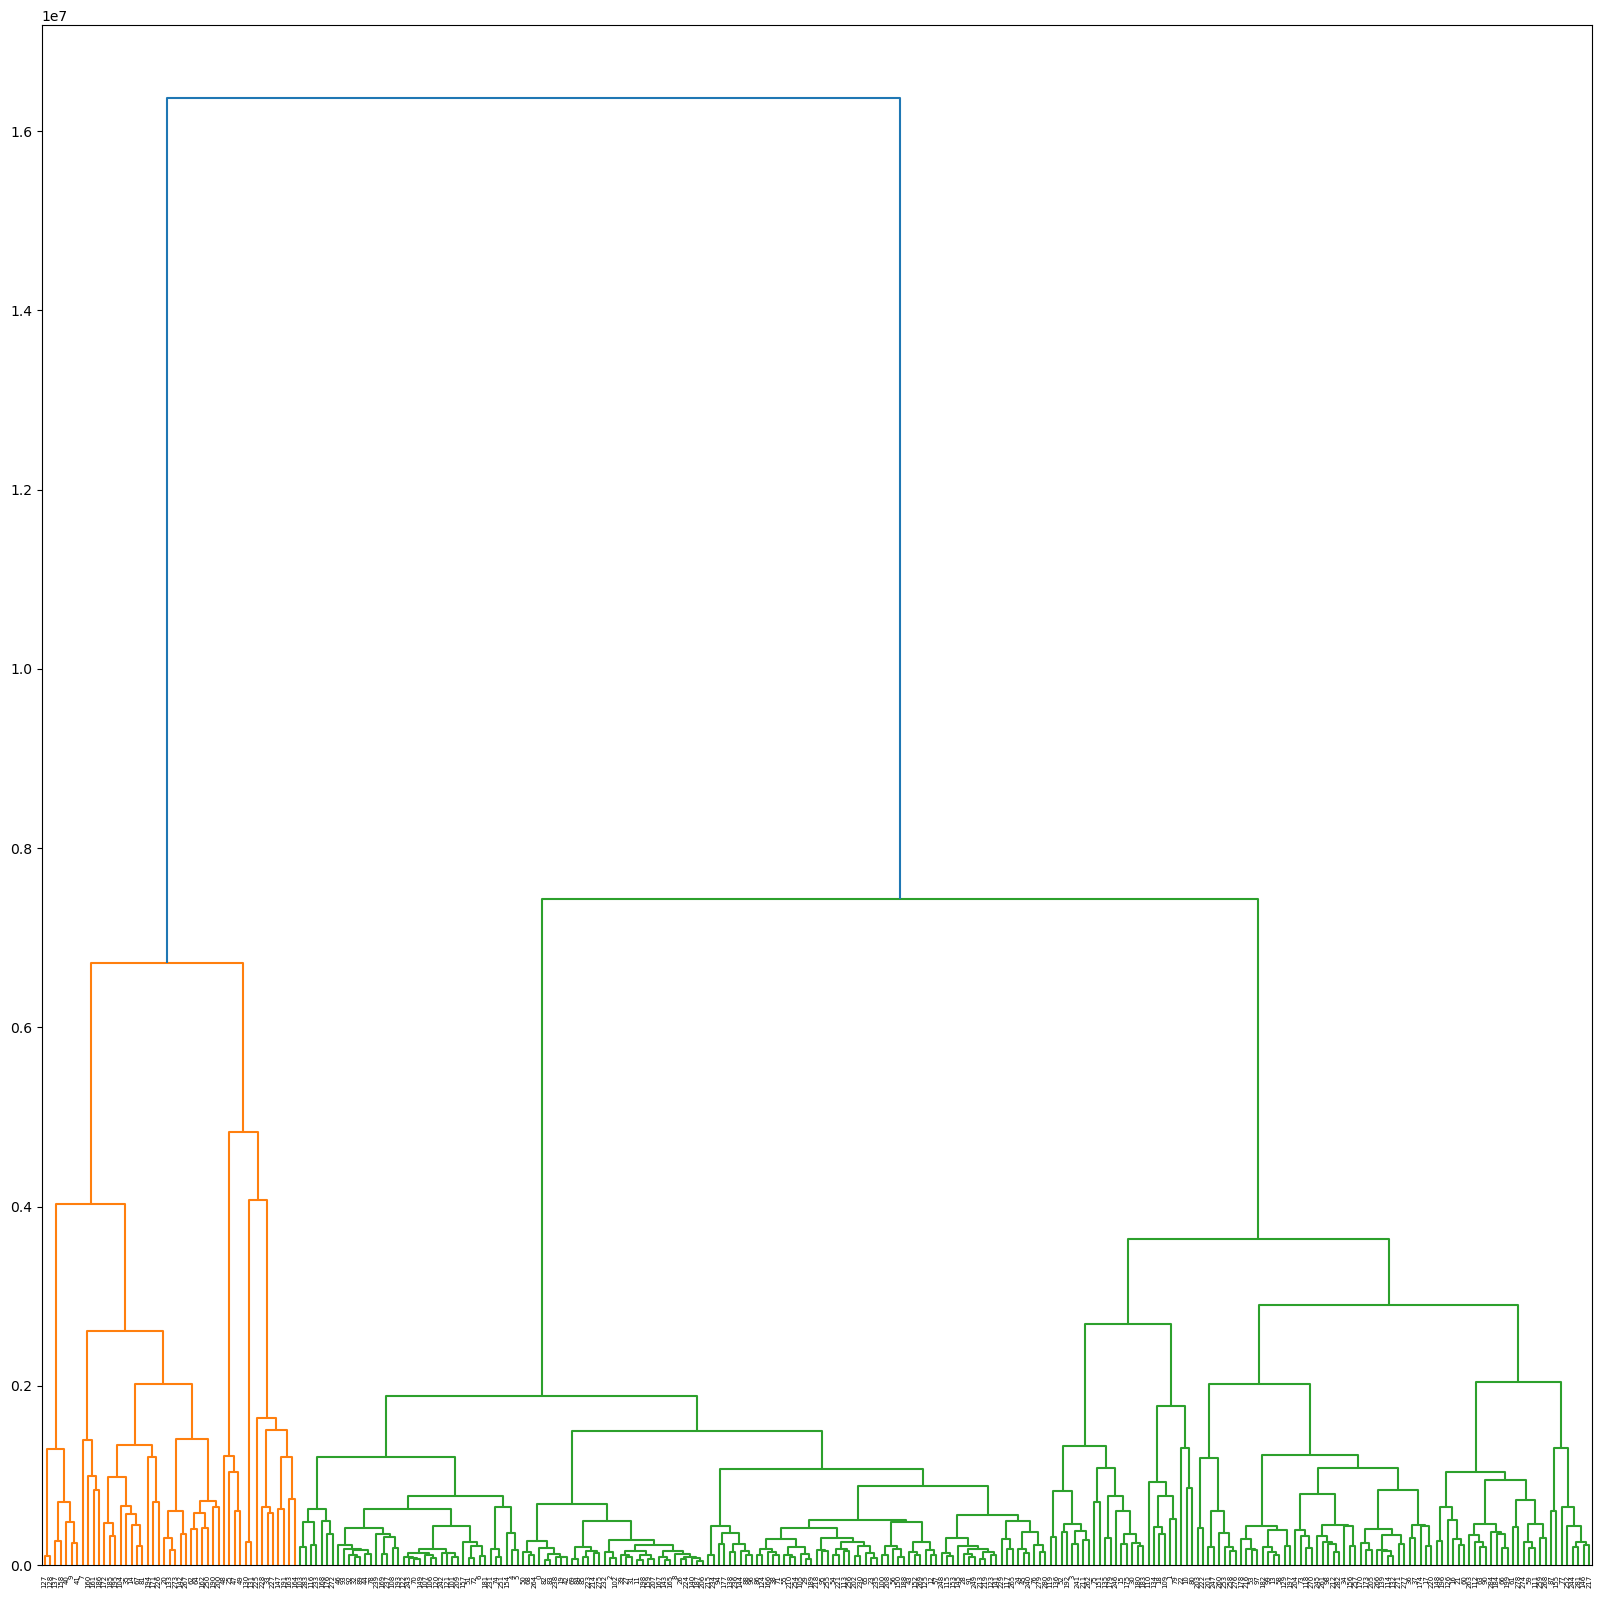

In [97]:
fig,ax = plt.subplots(figsize=(20,20))
_ = dendrogram(linkage_matrix, ax=ax)

In [117]:
clusters = fcluster(linkage_matrix, t=1.5e6, criterion='distance')

In [118]:
clusters

array([11, 13, 11, 12, 10, 10, 10,  2, 11,  1, 14, 11, 11, 16,  3, 12, 17,
       16, 13, 11,  4, 17, 14, 11, 11,  5, 11, 11, 11, 11, 12, 11, 10,  7,
       16,  3, 16, 16, 11, 11,  1,  1, 11, 11, 10, 11, 10,  5,  5,  5, 11,
       10, 12, 16, 11, 11, 11, 11, 16, 17, 17, 17,  4, 17,  4, 11, 17,  3,
       11, 11, 10, 11, 10, 16, 10, 12, 11, 18, 10, 13, 14,  3, 11, 11, 11,
       11, 11, 18, 11, 10, 17, 11, 10, 10, 11, 11, 11, 16, 16, 16, 11, 10,
       11, 10,  3, 11, 10, 10, 10, 13, 13, 17, 17, 11, 16, 11, 10, 11, 16,
       12, 10, 10, 10, 11, 11, 11, 17,  1,  1, 16,  6,  6, 16,  4, 13, 12,
       12,  1, 11, 16, 11, 11,  4, 11, 11, 11, 18,  8, 17, 10, 11, 12, 11,
       11, 10, 18, 16, 10,  1, 11,  2,  2,  4,  8,  8, 11, 11, 11, 10, 10,
       16,  3,  3, 16, 16, 12, 10, 11, 16, 12, 12, 10, 16, 12, 17,  3,  2,
       11, 11, 11,  4,  8, 12, 10,  3,  3, 17, 16, 11, 17,  4, 15, 11, 15,
       16, 16, 11, 11, 11, 10, 11, 12, 16, 11, 11, 11, 16, 18, 11, 11, 16,
       11, 15, 11, 11,  9

In [119]:
clusters = pd.Series(clusters, index=component_data.index.values)
clusters[-1] = -1
clusters = clusters.loc[results[label]].values

In [120]:
layer.get_fill_color = get_color(clusters)

In [146]:
from clustergram import Clustergram
from sklearn.mixture import GaussianMixture

In [150]:
component_data = X_train.loc[labels.groupby(labels).get_group(label).index.values]
component_data.shape

(60555, 63)

In [151]:
component_data = preprocess_clustering_data(component_data)
component_data.shape

(60555, 54)

In [ ]:
%%time
gmm = GaussianMixture(n_components=10, 
                      covariance_type="full",
                      max_iter=200, 
                      n_init=100,
                      random_state=42)
fitted = gmm.fit(component_data)
clusters = fitted.predict(component_data)
pd.Series(clusters, index=component_data.index).to_csv('../data/gmm_10_clusters.csv')

In [659]:
clusters = pd.read_csv('../data/gmm_10_clusters.csv').set_index('Unnamed: 0')